In [1]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from scipy import stats

In [2]:
alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/'
xr.open_dataset( '/home/gemeinsam_tmp/UA_students/data/Rio/Meteor_radar_Rio_wind_200810.h5', group='info')['day']

<xarray.DataArray 'day' (phony_dim_0: 744, phony_dim_1: 1)>
array([[ 1.],
       [ 1.],
       [ 1.],
       ...,
       [31.],
       [31.],
       [31.]])
Dimensions without coordinates: phony_dim_0, phony_dim_1
Attributes:
    day:      vector to constuct date and time

# Meteor radars

* Dav        Davis; GW:200501-201912
* Col         Collm (Leipzig); GW:200408-201903
* Rio         RioGrande (SAAMER- Argentina); GW:200802-201912
* Sod        Sodankyla; GW:200810-201912
* Kir          Kiruna (Sweden ? Esrange); GW:199908-201912
* CMA      CMOR (Canada ? CMA (CMOR All) triple frequency data); GW:200201-201812
* SES        Sodankyla ? Esrange merged (assigned either to Esrange or Sodankyla or a virtual center in between); GW:199908-201912


Dav_start = '2005-01-'
Dav_end = '2019-12-'
Col_start = '2004-08-01'
Col_end='2019-03-06'
Rio_start = '2008-02-01'
Rio_end = '2019-12-31'
Sod_start = '2008-10-'
Sod_end = '2019-12-'
Kir_start = '1999-08-'
Kir_end = '2019-12-'
Cma_start = '2002-01-01'
Cma_end = '2018-12-31'
Ses_start = '1999-08-'
Ses_end = '2019-12-'


# FUNCTIONS

### lineare regression

In [41]:
def new_linregress(y):
   
    
    mask = ~np.isnan(y)
    #print('y: '+str(y))
    #print('x: '+str(x))
    
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    return np.array([slope, intercept, r_value, p_value, std_err])
    

In [42]:
def new_linregress_masked(y):
   
    
    mask = ~np.isnan(y)
    #print('y: '+str(y))
    #print('x: '+str(x))
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    return np.array([slope, intercept, r_value, p_value, std_err])
    

In [4]:
def time_reg(var):
        #print('var:'+str(var.values))
        statistics = xr.apply_ufunc(new_linregress, var, 
                       input_core_dims=[['time']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="allowed",
                       output_dtypes=['float64'],
                       #output_sizes={"parameter": 5},
                      )
        return statistics

In [43]:
def time_reg_masked(var):
        #print('var:'+str(var.values))
        statistics = xr.apply_ufunc(new_linregress_masked, var, 
                       input_core_dims=[['time']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="allowed",
                       output_dtypes=['float64'],
                       #output_sizes={"parameter": 5},
                      )
        return statistics

In [5]:
def is_mon(month,sta,end):
    return (month >= sta) & (month <= end)

### Variable einlesen

In [6]:
def read_group(gruppe,loc):
    station = loc#ersten Buchstaben bitte bitte groß schreiben
    
    if loc=='Rio':
        timestart = '2008-02-01'
        timeend = '2019-12-31'
    elif loc == 'Col':
        timestart =  '2004-08-01'
        timeend =  '2019-03-06'
    elif loc=='CMA':
        timestart = '2002-01-01'
        timeend = '2018-12-31'
    infiles = f'{root_path}{station}/Meteor_radar_{station}_GW_*.h5'
    ds = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_6', group = gruppe, combine='nested', parallel = True)
    ds = ds.rename({'phony_dim_6': 'time', 'phony_dim_7': 'alt'})
    ds['alt'] = alt
    ds['alt'].attrs['units'] = 'km'
    # change time range according to meteor radar station
    ds['time'] = pd.date_range(start = timestart, end = timeend, periods = ds.time.shape[0]) 
    return ds
    

In [7]:
def read_var(gruppe, var):
        varout = gruppe[var]
        return varout

### Horizontal Wind

In [8]:
def hwind(u,v):
    return np.sqrt(u**2+v**2)
    

### time mean

In [9]:
def time_mean(step,var):
    return var.resample(time='1'+step).mean('time') #Immer nur D oder M oder H oder Y eintragen! Mit Anführungszeichen!
    
    

### Amomalies

In [10]:
def anomalie(step,var):
    string = "time."+step   
    climatology = var.groupby(string).mean("time")
    anomalies = var.groupby(string) - climatology
    
    return anomalies




## Collm

In [11]:
ds_col= read_group('wind','Col')
u_col = read_var(ds_col,'u')  
v_col = read_var(ds_col,'v')

u_col_monano = anomalie('month',u_col)
v_col_monano = anomalie('month',v_col)

u_col_monthly_ano = time_mean('M',u_col_monano)
v_col_monthly_ano = time_mean('M',v_col_monano)

u_col_monthly = time_mean('M',u_col)
v_col_monthly = time_mean('M',v_col)

In [12]:
u_col_yearano = anomalie('month',u_col)
v_col_yearano = anomalie('month',v_col)

u_col_yearly_ano = time_mean('Y',u_col_yearano)
v_col_yearly_ano = time_mean('Y',v_col_yearano)

In [13]:
print(u_col_monano.shape)
print(u_col_monano.time.shape)
print(u_col_monano.alt.shape)

(127944, 26)
(127944,)
(26,)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


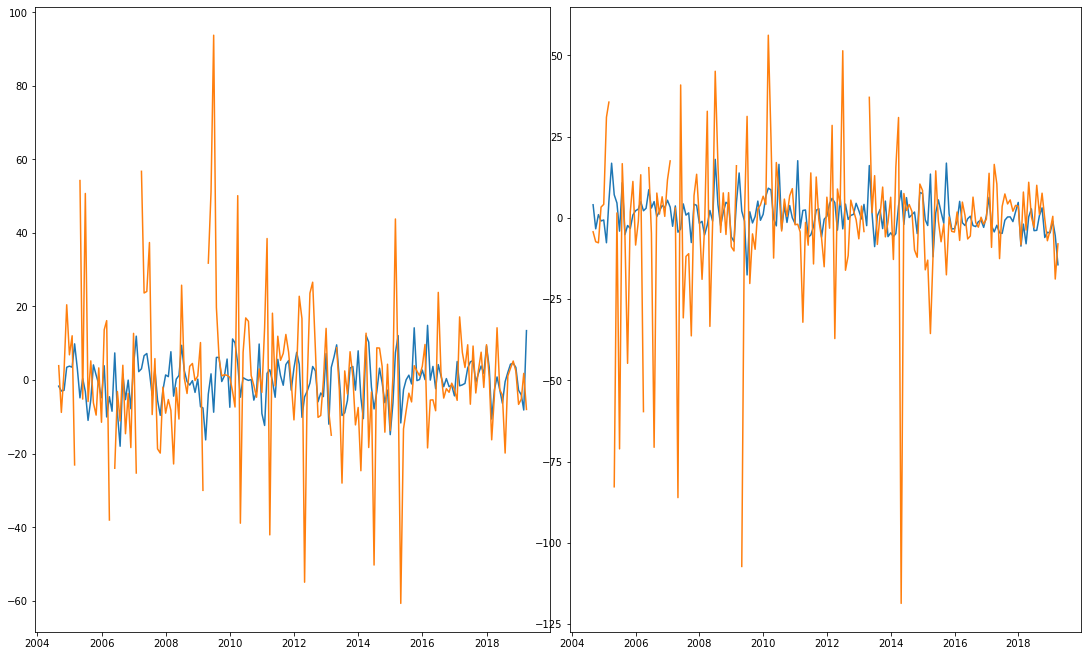

In [29]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])

windsel=u_col_monthly_ano.sel(alt = [103,108], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_col_monthly_ano.time,windsel)

windsel=v_col_monthly_ano.sel(alt = [103,108], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(u_col_monthly.time,windsel)


<xarray.DataArray 'u' (time: 176, alt: 26)>
dask.array<stack, shape=(176, 26), dtype=float64, chunksize=(1, 26), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2004-08-31 2004-09-30 ... 2019-03-31
  * alt      (alt) int64 70 72 74 76 78 80 82 84 ... 108 110 112 114 116 118 120


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


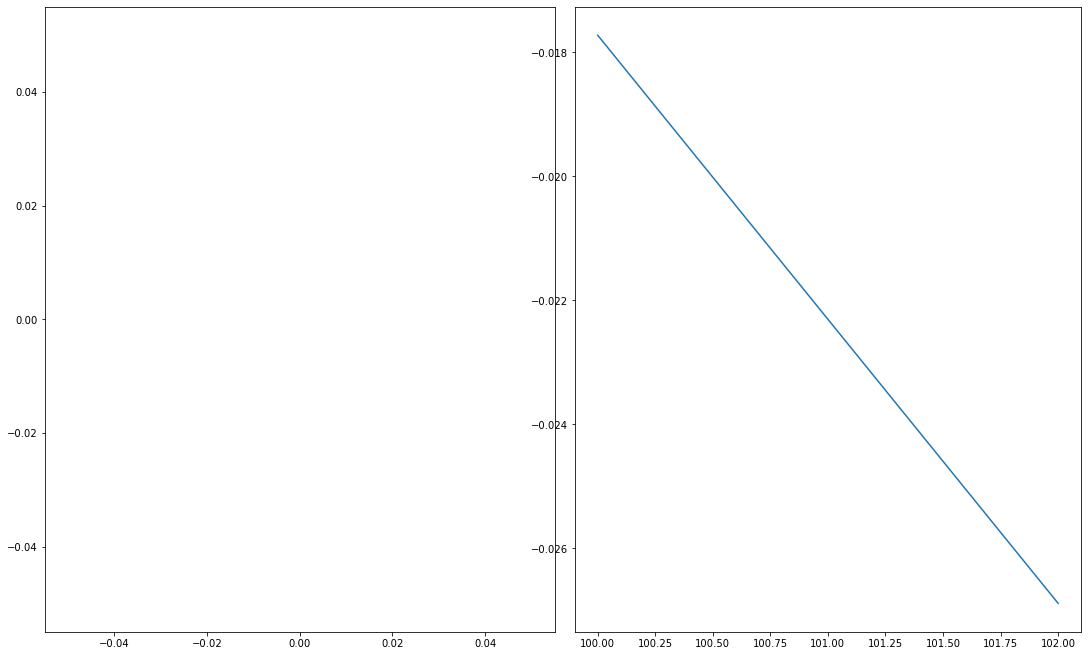

In [44]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])


ax1 = fig.add_subplot(121)
x = np.arange(u_col_monthly.time.shape[0])
print(u_col_monthly)
statistics = time_reg_masked(u_col_monthly)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax1.plot(u_col_monthly.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))




ax2 = fig.add_subplot(122)
x = np.arange(v_col_monthly.time.shape[0])
statistics = time_reg(v_col_monthly)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax2.plot(v_col_monthly.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))

#### Analyse Months seperatly

In [31]:
#Analyse Months seperatly
s = 1
e = 1
u_col_examon = u_col_monthly_ano.sel(time=is_mon(u_col_monthly_ano['time.month'],s,e))
v_col_examon = v_col_monthly_ano.sel(time=is_mon(v_col_monthly_ano['time.month'],s,e))


x = np.arange(u_col_examon.time.shape[0])



/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


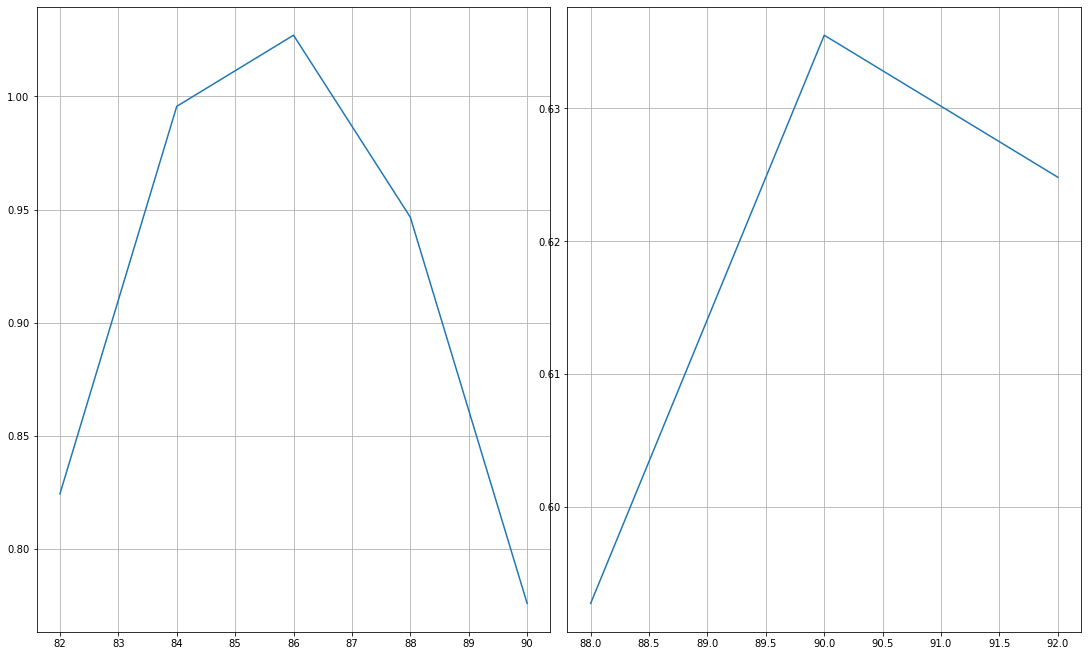

In [45]:
#plot STATISTICS

fig = plt.figure(constrained_layout=True,figsize = [15,9])


ax1 = fig.add_subplot(121)
x = np.arange(np.squeeze(u_col_examon.time.shape))
#print('ucolexamon: '+str(u_col_examon))
statistics = time_reg(u_col_examon)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax1.plot(u_col_examon.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))
ax1.grid()



ax2 = fig.add_subplot(122)
x = np.arange(np.squeeze(v_col_examon.time.shape))
statistics = time_reg(v_col_examon)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax2.plot(v_col_examon.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))
ax2.grid()

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


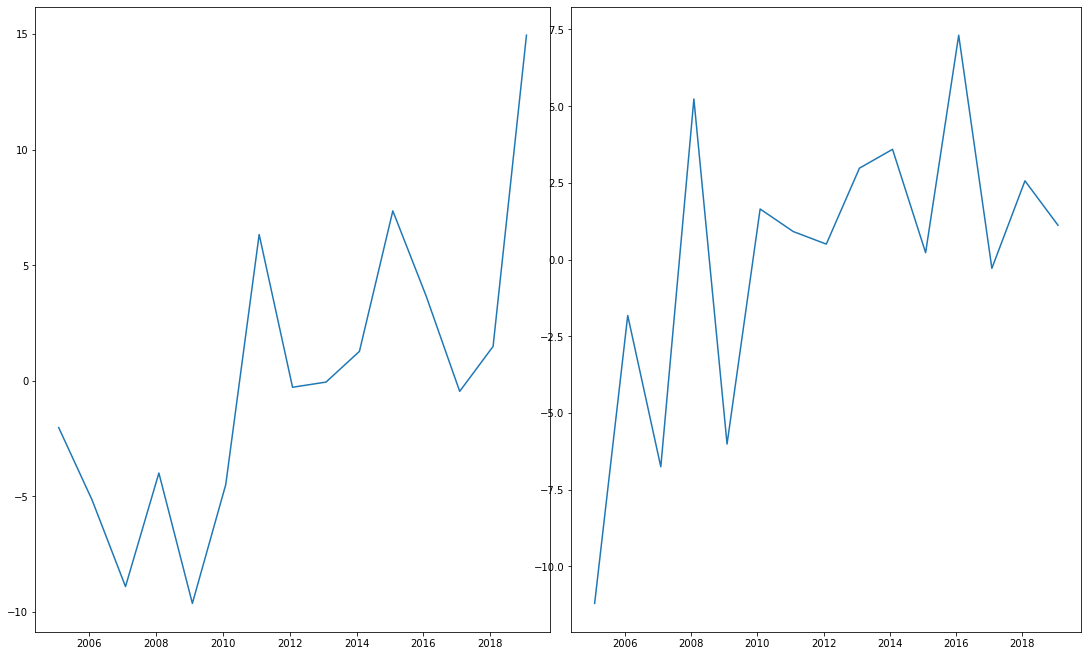

In [46]:
#plot actual DATA

fig = plt.figure(constrained_layout=True,figsize = [15,9])

windsel=u_col_examon.sel(alt = [86], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_col_examon.time,windsel)
test=np.arange(15)
windsel=v_col_examon.sel(alt = [90], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(v_col_examon.time,windsel)

## RIO

In [17]:
ds_rio= read_group('wind','Rio')
u_rio = read_var(ds_rio,'u')  
v_rio = read_var(ds_rio,'v')

u_rio_monano = anomalie('month',u_rio)
v_rio_monano = anomalie('month',v_rio)

u_rio_monthly_ano = time_mean('M',u_rio_monano)
v_rio_monthly_ano = time_mean('M',v_rio_monano)

u_rio_monthly = time_mean('M',u_rio)
v_rio_monthly = time_mean('M',v_rio)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


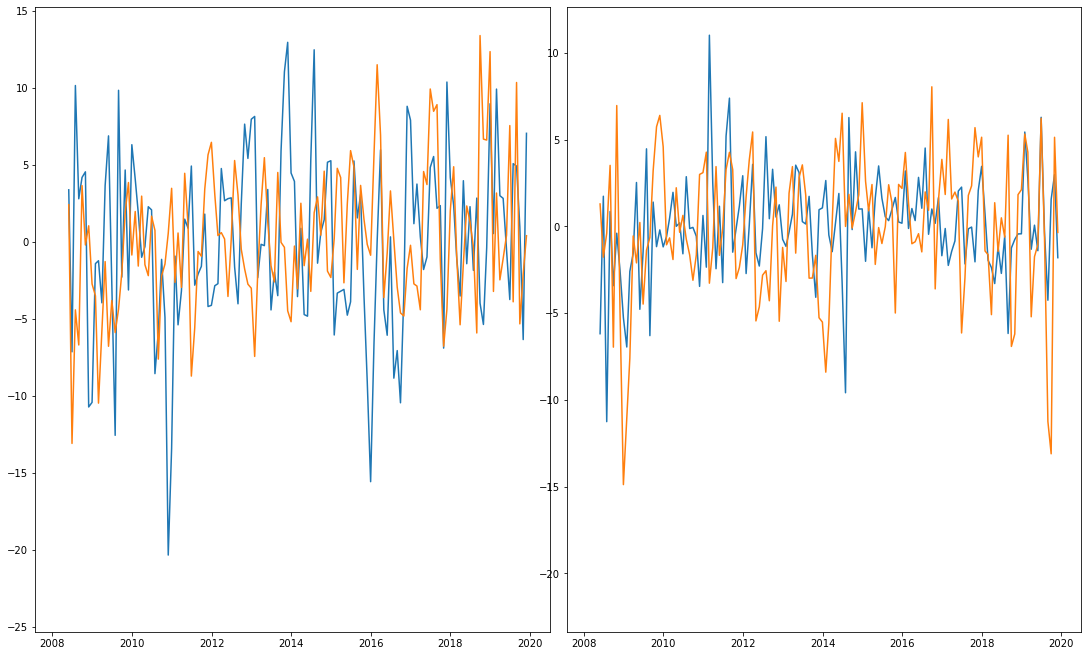

In [47]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])

windsel=u_rio_monthly_ano.sel(alt = [90,105], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_rio_monthly_ano.time,windsel)

windsel=v_rio_monthly_ano.sel(alt = [90,105], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(u_rio_monthly.time,windsel)


<xarray.DataArray 'u' (time: 143, alt: 26)>
dask.array<stack, shape=(143, 26), dtype=float64, chunksize=(1, 26), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2008-02-29 2008-03-31 ... 2019-12-31
  * alt      (alt) int64 70 72 74 76 78 80 82 84 ... 108 110 112 114 116 118 120


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


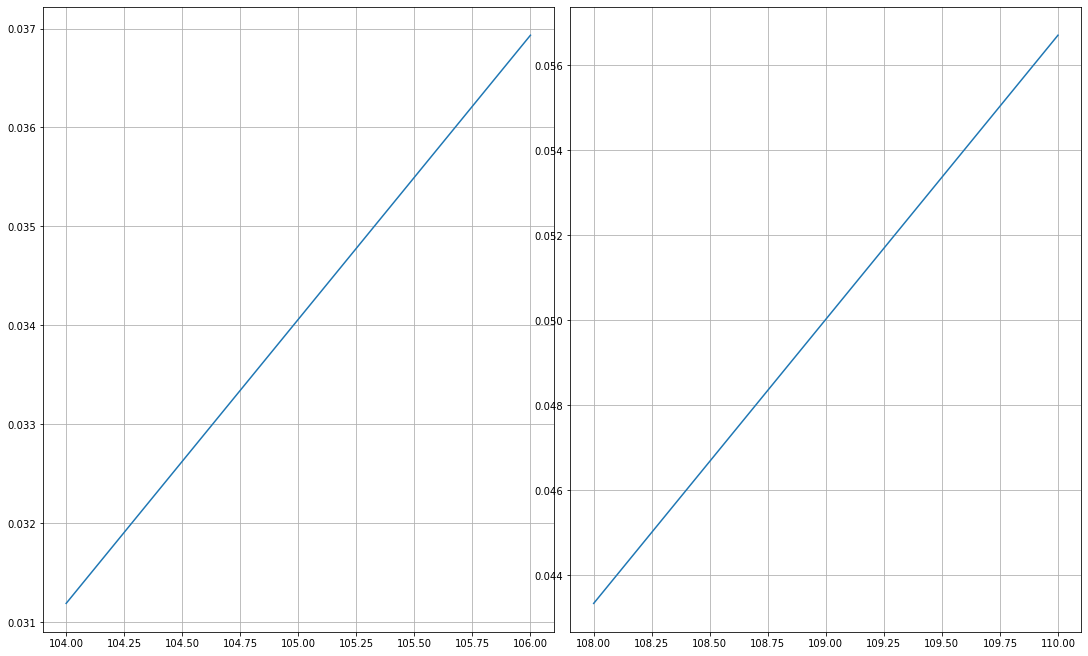

In [56]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])


ax1 = fig.add_subplot(121)
x = np.arange(u_rio_monthly.time.shape[0])
print(u_rio_monthly)
statistics = time_reg_masked(u_rio_monthly)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax1.plot(u_rio_monthly.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))
ax1.grid()                                                                  




ax2 = fig.add_subplot(122)
x = np.arange(v_rio_monthly.time.shape[0])
statistics = time_reg_masked(v_rio_monthly)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax2.plot(v_rio_monthly.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))
ax2.grid()

#### Analyse months seperatly

In [50]:
#Analyse Months seperatly
s = 1
e = 1
u_rio_examon = u_rio_monthly_ano.sel(time=is_mon(u_rio_monthly_ano['time.month'],s,e))
v_rio_examon = v_rio_monthly_ano.sel(time=is_mon(v_rio_monthly_ano['time.month'],s,e))


x = np.arange(u_rio_examon.time.shape[0])


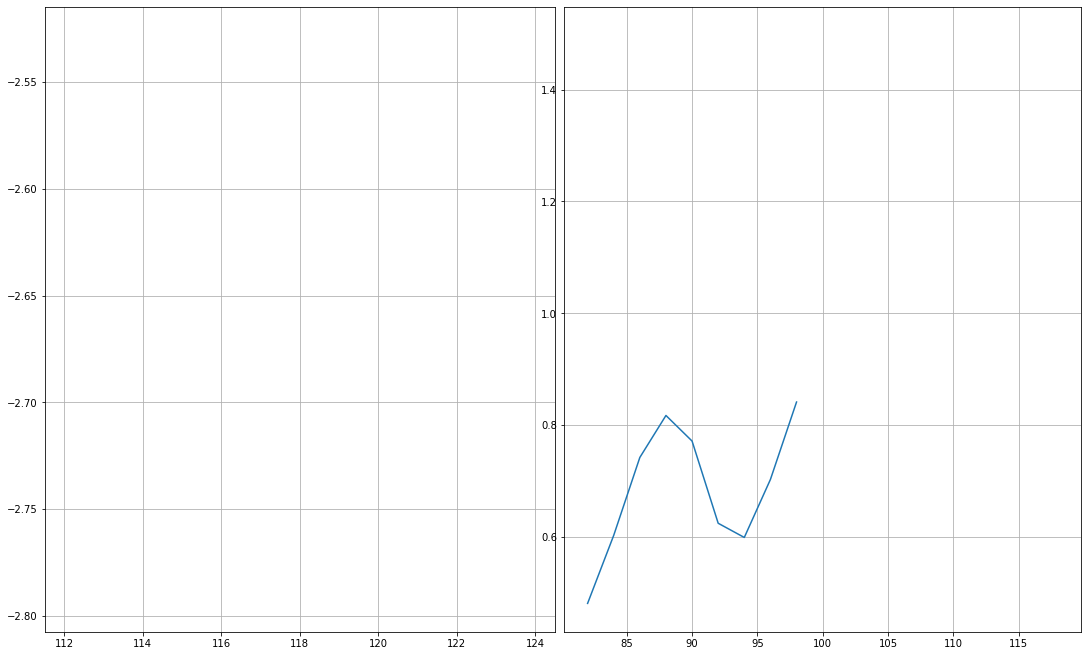

In [51]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])


ax1 = fig.add_subplot(121)
x = np.arange(np.squeeze(u_rio_examon.time.shape))
#print('urioexamon: '+str(u_rio_examon))
statistics = time_reg(u_rio_examon)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax1.plot(u_rio_examon.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))
ax1.grid()



ax2 = fig.add_subplot(122)
x = np.arange(np.squeeze(v_rio_examon.time.shape))
statistics = time_reg(v_rio_examon)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax2.plot(v_rio_examon.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))
ax2.grid()

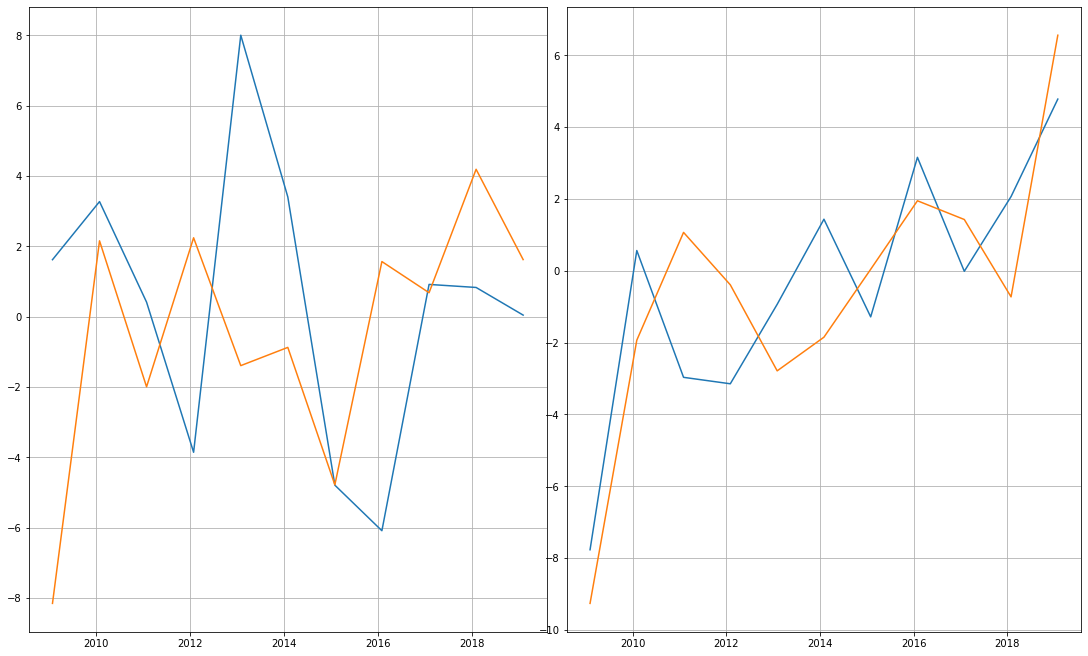

In [64]:
#plot actual DATA

fig = plt.figure(constrained_layout=True,figsize = [15,9])

windsel=u_rio_examon.sel(alt = [87,97], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_rio_examon.time,windsel)
ax1.grid()


windsel=v_rio_examon.sel(alt = [87,97], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(v_rio_examon.time,windsel)
ax2.grid()

## CMA

In [20]:
ds_cma= read_group('wind','CMA')
u_cma = read_var(ds_cma,'u')  
v_cma = read_var(ds_cma,'v')

u_cma_monano = anomalie('month',u_cma)
v_cma_monano = anomalie('month',v_cma)

u_cma_monthly_ano = time_mean('M',u_cma_monano)
v_cma_monthly_ano = time_mean('M',v_cma_monano)

u_cma_monthly = time_mean('M',u_cma)
v_cma_monthly = time_mean('M',v_cma)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


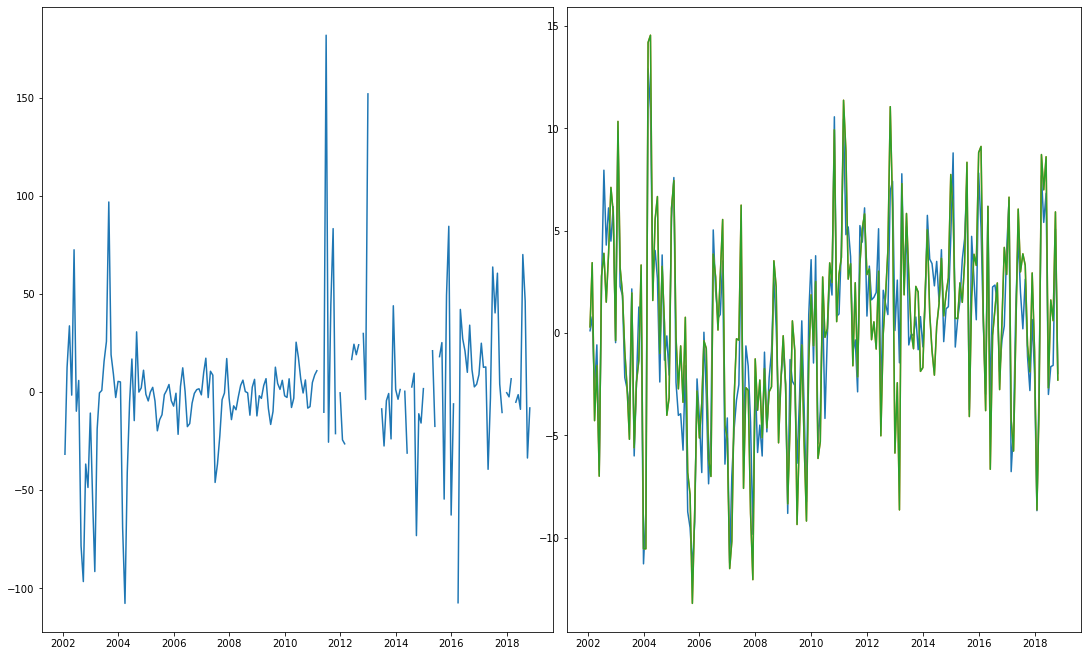

In [21]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])

windsel=u_cma_monthly_ano.sel(alt = [118], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_cma_monthly_ano.time,windsel)

windsel=v_cma_monthly_ano.sel(alt = [106,107,108], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(u_cma_monthly.time,windsel)


<xarray.DataArray 'u' (time: 204, alt: 26)>
dask.array<stack, shape=(204, 26), dtype=float64, chunksize=(1, 26), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2018-12-31
  * alt      (alt) int64 70 72 74 76 78 80 82 84 ... 108 110 112 114 116 118 120


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


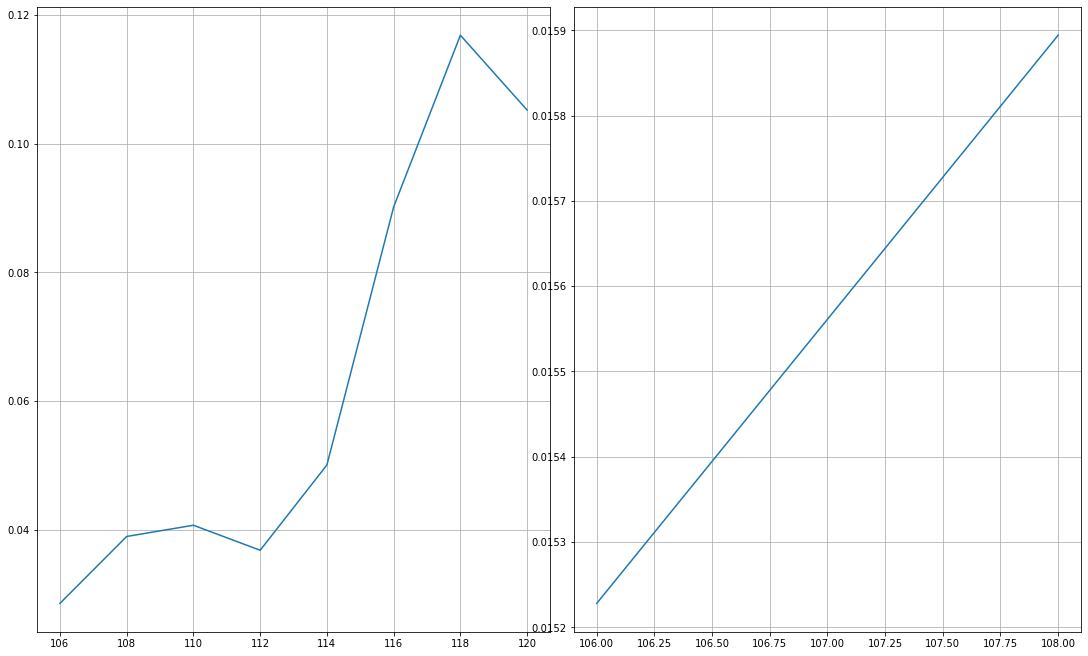

In [55]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])


ax1 = fig.add_subplot(121)
x = np.arange(u_cma_monthly.time.shape[0])
print(u_cma_monthly)
statistics = time_reg_masked(u_cma_monthly)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax1.plot(u_cma_monthly.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))
ax1.grid()                                                                  




ax2 = fig.add_subplot(122)
x = np.arange(v_cma_monthly.time.shape[0])
statistics = time_reg_masked(v_cma_monthly)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax2.plot(v_cma_monthly.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))
ax2.grid()

#### analyze Months speratly

In [60]:
#Analyse Months seperatly
s = 1
e = 1
u_cma_examon = u_cma_monthly_ano.sel(time=is_mon(u_cma_monthly_ano['time.month'],s,e))
v_cma_examon = v_cma_monthly_ano.sel(time=is_mon(v_cma_monthly_ano['time.month'],s,e))


x = np.arange(u_cma_examon.time.shape[0])


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


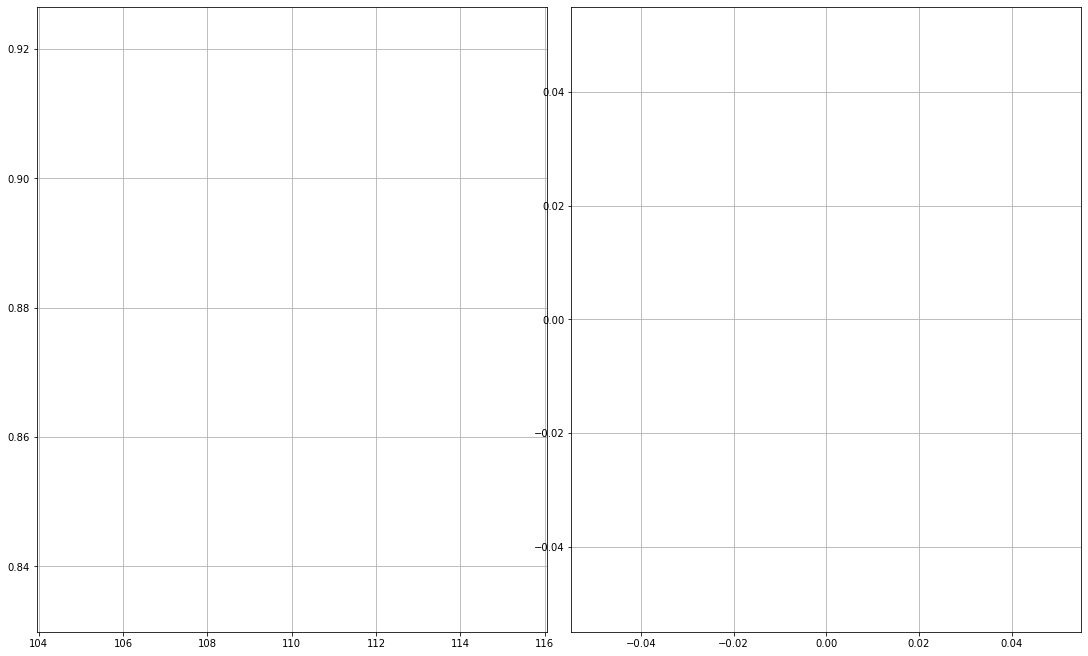

In [63]:
fig = plt.figure(constrained_layout=True,figsize = [15,9])


ax1 = fig.add_subplot(121)
x = np.arange(np.squeeze(u_cma_examon.time.shape))
#print('ucmaexamon: '+str(u_cma_examon))
statistics = time_reg(u_cma_examon)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax1.plot(u_cma_examon.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))
ax1.grid()



ax2 = fig.add_subplot(122)
x = np.arange(np.squeeze(v_cma_examon.time.shape))
statistics = time_reg(v_cma_examon)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
ax2.plot(v_cma_examon.alt,statistics.sel(parameter='slope').where(statistics.sel(parameter='p_value')<= 0.05))
ax2.grid()

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


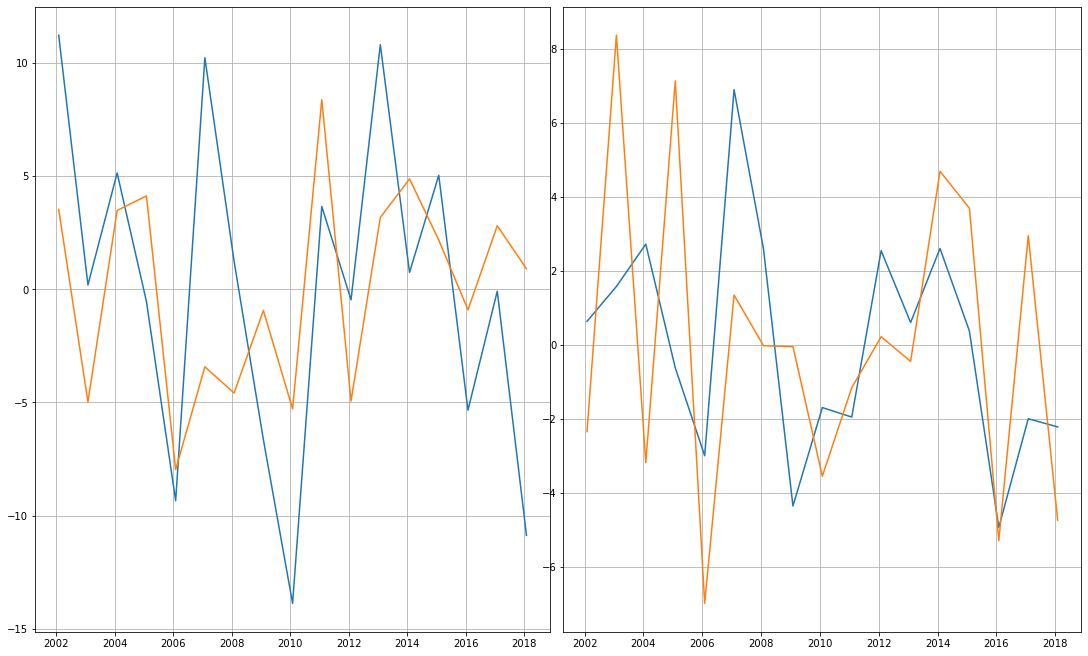

In [65]:
#plot actual DATA

fig = plt.figure(constrained_layout=True,figsize = [15,9])

windsel=u_cma_examon.sel(alt = [87,97], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_cma_examon.time,windsel)
ax1.grid()


windsel=v_cma_examon.sel(alt = [87,97], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(v_cma_examon.time,windsel)
ax2.grid()

### Gravity waves

#### Climatology calculation

# GAIA

## Rio

In [23]:
root_path = '/projekt4/hochatm/akuchar/GAIA_analysis/'
infile = f'{root_path}GAIA_Rio_20080201_20141231_run20200327.nc'
ds = xr.open_dataset(infile, group='GAIA')
ds['time'] = pd.date_range(start = '2008-02-01', end = '2014-12-31', periods=ds.time.shape[0])
ds

FileNotFoundError: [Errno 2] No such file or directory: b'/projekt4/hochatm/akuchar/GAIA_analysis/GAIA_Rio_20080201_20141231_run20200327.nc'

### Tides amplitude in zonal wind (climatology)

#### Diurnal

In [ ]:
temp = ds['A24u'].sel(alt = slice(80,100)).groupby('time.month').mean('time')
temp.plot.contourf(x = 'month', robust = True, levels = 21)

#### Semi-diurnal

In [ ]:
temp = ds['A12u'].sel(alt = slice(80,100)).groupby('time.month').mean('time')
temp.plot.contourf(x = 'month', robust = True, levels = 21)

#### Terdiurnal

In [ ]:
temp = ds['A8u'].sel(alt = slice(80,100)).groupby('time.month').mean('time')
temp.plot.contourf(x = 'month', robust = True, levels = 21)

### Gravity waves

In [ ]:
var = 'u'
da_gwu = ds[var]-ds[f'{var}_fil']
var = 'v'
da_gwv = ds[var]-ds[f'{var}_fil']
da_gw_total = 0.5*(da_gwu**2+ da_gwv**2)
da_gw_total_clim = da_gw_total.groupby('time.month').mean('time')
da_gw_total_clim

In [ ]:
da_gw_total.plot(x = 'time', robust = True)

In [ ]:
da_gw_total.sel(alt = slice(60,120)).plot(x = 'time', robust = True)

#### Climatology

In [ ]:
da_gw_total_clim.sel(alt = slice(50,150)).plot(x = 'month', robust = True)